# Our process for fine-tuning Llama 2 with custom data

We successfully trained LLaMA-2-7b-hf on a custom dataset to perform a single, routine task (keyword extraction). We thought this would be easy, but it was WAY HARDER than we expected. We went down a lot of wrong turns, and many of the notebooks/code examples either didn't work or were improperly documented. 

**Much of the code in this notebook is borrowed from other walkthroughs. There are a few key changes that took us a while to figure out, and so we were inspired to share.**

# What you'll need...

1. About **10K inputs and outputs** you'd like to train the model on. We generated these using some python scripts and openai's gpt3.5. For us, the average total token count of each input/output pair was ~300, and **no pair was longer than 800 tokens**.
2. A **runpod account**, and about **~$25**. That's what it cost us, once we had everything figured out. 
3. **ChatGPT** open in another tab. This notebook works for us as of **September 2023** but there's no gaurantee it'll work for you. With any luck, you (and ChatGPT) should be able to overcome any obstacles that arise. 
4. About **2 hours** of setup and the patience to wait **5-8 hours** for results.

# Getting set up in Runpod

1. Make an account (at runpod.io) and fund it
2. Select an **A100** (it's what we used, use a lesser GPU at your own risk) from the **Community Cloud** (it doesn't really matter, but it's slightly cheaper)
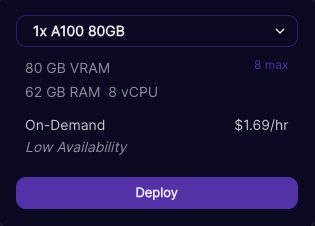

3. For template, select **Runpod Pytorch 2.0.1**

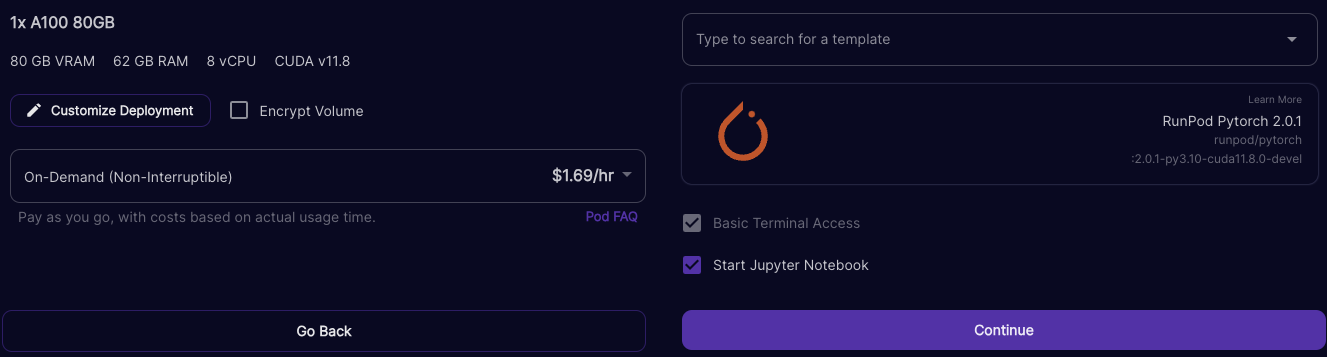




4. Wait a minute or so for it to load up
5. Click **connect**
6. Click on the button to connect to **Jupyter Lab [Port 888]**

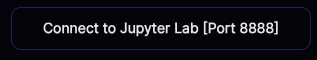


7. Create a **new notebook**, and you should be ready to go!

# Preparing your data

This is probably the most important and frusterating part! Of course you want to make sure your input/output data is quality, and that you have enough of it (~10K rows, for us). 

Once you've got that, you'll want to format it. You're gonna want to format it ***exactly like [this](https://huggingface.co/datasets/timdettmers/openassistant-guanaco/blob/main/openassistant_best_replies_train.jsonl)***. I would recommend downloading the jsonl file and taking a look.

You need a `.jsonl` file structured like this:

```
{"text": "### Human: YOURINSTRUCTIONHERE: YOURINPUT1HERE ### Assistant: YOUROUTPUT1HERE"}
{"text": "### Human: YOURINSTRUCTIONHERE: YOURINPUT2HERE ### Assistant: YOUROUTPUT2HERE"}
{"text": "### Human: YOURINSTRUCTIONHERE: YOURINPUT3HERE ### Assistant: YOUROUTPUT3HERE"}
```

Here's an explanation of the above:
1. **YOURINPUTXHERE:** Your inputs. If you were doing keyword extraction, this would be the text you're extracting from
2. **YOUROUTPUTXHERE:** Your outputs, properly formated. If you wanted your keywords as a list, these would be the training outputs formatted like this: ["yes","no","cool"]
3. **YOURINSTRUCTIONHERE:** This is the instruction. We think of it as a short (one or two sentence) reminder to the model of what to do. It'll really help training go faster. It should be the same for every one if you're training on a specific task. For keyword extraction, it'd be something like: ```"Extract relevant keywords from the following text."```


This isn't the only way to do it, but it's the way we finally got things to work. Make sure your file **doesn't have any extra lines or characters**, and that your data is **sanitized properly**. The formatting can be really annoying. We used a python script to generate the file. 


Once you have it, **name it `data.jsonl`** drag and drop it **into your jupyter lab directory**.

# Access to Llama2 (and the license)

The great thing about Llama 2 is that it has a commercial license. But you have to go to meta and accept that license. 
1. Make a huggingface account (if you don't have one already)
2. ***Request access [here](https://ai.meta.com/resources/models-and-libraries/llama-downloads/)*** and make sure you use the same email as your hugging face account (**very important**)
3. You should get an email from meta within 5 minutes. 
4. Now, you'll need to ***request access [here](https://huggingface.co/meta-llama/Llama-2-7b-hf)*** for the model on huggingface. 
5. Once they give it to you (it usually takes about an hour), go to your user settings, **Access Tokens**, and create (and copy) a new access token.

# Training

You can copy and paste cell by cell into your new runpod notebook, or you can upload this notebook and use it directly.

In [ ]:
%%capture #Remove this if you're having problems, it just makes these not print output
!pip uninstall transformers --yes #You'll need a special, different transformers
!pip install -q -U datasets peft trl bitsandbytes transformers[torch] scipy tqdm 

In [ ]:
import os
from dataclasses import dataclass, field
from typing import Optional

import torch
from datasets import load_dataset
from datasets import load_from_disk
from peft import LoraConfig
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
)
from tqdm.notebook import tqdm

from trl import SFTTrainer
from huggingface_hub import interpreter_login

### Add your own token after running the line below

In [ ]:
interpreter_login()

In [ ]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype='float16',
        bnb_4bit_use_double_quant=False,
    )
device_map = {"": 0}

In [ ]:
#Download model
model = AutoModelForCausalLM.from_pretrained(
        "meta-llama/Llama-2-7b-hf", 
        quantization_config=bnb_config, 
        device_map=device_map, 
        use_auth_token=True
    )

In [ ]:
model.config.pretraining_tp = 1 
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=.1,
    r=32,
    bias="none",
    task_type="CAUSAL_LM", 
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
training_arguments = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    save_steps=500, #CHANGE THIS IF YOU WANT IT TO SAVE LESS OFTEN. I WOULDN'T SAVE MORE OFTEN BECAUSE OF SPACE
    logging_steps=10,
    learning_rate=2e-4,
    fp16=False,
    bf16=True,
    max_grad_norm=.3,
    max_steps=10000,
    warmup_ratio=.03,
    group_by_length=True,
    lr_scheduler_type="constant",
)

In [ ]:
model.config.use_cache = False

### Load in your data here....

In [ ]:
dataset = load_dataset("json", data_files="data.jsonl", split="train")

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
)

### The main event... training

This took between **2 and 8 hours** for us depending on amount of data and other factors. It is currently configured to go to **10K steps**, saving a **checkpoint after every 500 steps**. These checkpoints can be **very large**, on the order of **1-2GB**. It is noted above where you could change this as needed.

Even if you stop early, you can **restart training** like this: ```trainer.train(resume_from_checkpoint=True)```

Futher, you're saving a **checkpoint every 500 steps**, so you can run the model and test performance as you go along!

In [ ]:
trainer.train()

# Saving your Model to HF

At any point, you can save your model to HF using the below code. You can manage privacy and stuff on HF

In [ ]:
model.push_to_hub("YOURUSERNAME/WHATEVER", use_auth_token=True)

# Running Inference as you go

You can stop anytime, and run the model from any checkpoint (multiple of 500) using the code here!

In [ ]:
from peft import PeftModel
model = PeftModel.from_pretrained(model, "results/checkpoint-2000")

In [2]:
def make_prompt(entry):
    return f"### Human: YOUR INSTRUCTION HERE: {entry} ### Assistant:"

In [4]:
def run_model(entry):
    model_input = tokenizer(
        make_prompt(entry),
        return_tensors="pt").to("cuda")

    input_length = len(model_input['input_ids'][0])
    model.eval()
    with torch.no_grad():
        full_tokens = model.generate(**model_input, max_new_tokens=100)[0]
        decoded_tokens = tokenizer.decode(full_tokens[input_length:], skip_special_tokens=True)
    return decoded_tokens

In [ ]:
run_model("Hello! Here's my example of an input you might test...")

# Running Inference Later (maybe in Google Colab)

We found that you have to adjust settings slightly to get things to run in google colab. Likewise, every environment will differ. What follows is the code we used, in google colab. If you're doing it in colab, **don't forget to change the instance type to T4**. 

In [ ]:
%%capture
!pip install transformers[torch]
!pip install peft
!pip install datasets
!pip install bitsandbytes
!pip install tqdm
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from peft import PeftModel
from tqdm.notebook import tqdm

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_4bit_compute_dtype=torch.float16,
)

In [ ]:
base_model_name="meta-llama/Llama-2-7b-hf"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True,
    use_auth_token=True
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

### Input your own model here, as you saved it in the above step

In [ ]:
model = PeftModel.from_pretrained(base_model,
                                  "YOURUSERNAME/WHATEVER",
                                  use_auth_token=True)

In [ ]:
def make_prompt(entry):
    return f"### Human: YOUR INSTRUCTION HERE: {entry} ### Assistant:"

In [ ]:
def run_model(entry):
    model_input = tokenizer(
        make_prompt(entry),
        return_tensors="pt").to("cuda")

    input_length = len(model_input['input_ids'][0])
    model.eval()
    with torch.no_grad():
        full_tokens = model.generate(**model_input, max_new_tokens=100)[0]
        decoded_tokens = tokenizer.decode(full_tokens[input_length:], skip_special_tokens=True)
    return decoded_tokens

In [ ]:
run_model("Hello! Here's my example of an input you might test...")